# Import Library

In [ ]:
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_datasets import as_numpy
import numpy as np
import os
import glob
import cv2

In [ ]:
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

# Data Load

In [ ]:
batch_size = 16
img_height = 256
img_width = 256

In [ ]:
# 19 categories
label_list = ['skin', 'nose', 'eye_g'
              , 'l_eye', 'r_eye', 'l_brow'
              , 'r_brow', 'l_ear', 'r_ear'
              , 'mouth', 'u_lip', 'l_lip'
              , 'hair', 'hat', 'ear_r'
              , 'neck_l', 'neck', 'cloth']

color_list = [[0, 0, 0]
              , [204, 0, 0], [76, 153, 0], [204, 204, 0]
              , [51, 51, 255], [204, 0, 204], [0, 255, 255]
              , [255, 204, 204], [102, 51, 0], [255, 0, 0]
              , [102, 204, 0], [255, 255, 0], [0, 0, 153]
              , [0, 0, 204], [255, 51, 153], [0, 204, 204]
              , [0, 51, 0], [255, 153, 51], [0, 204, 0]]

face_labels = [0,2,4,5,6,7,10,11,12]

In [ ]:
def crop_face_region(path, margin=10, target_size=256):
    # load the image
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray[gray != 0] = 255

    # find border pixel
    border = np.where(gray == 255)
    x_min, x_max = border[1].min(), border[1].max()
    y_min, y_max = border[0].min(), border[0].max()

    # crop the target region
    crop = img[y_min:y_max+1, x_min:x_max+1]
    crop_size = max(x_max-x_min, y_max-y_min)

    canvas = np.zeros((crop_size+10, crop_size+10)).astype(np.uint8)

    center_x, center_y = canvas.shape[0]//2, canvas.shape[0]//2
    size_y, size_x = (y_max-y_min)//2, (x_max-x_min)//2
    lefttop_point_y, lefttop_point_x = center_y-size_y, center_x-size_x
    canvas[lefttop_point_y:lefttop_point_y+(y_max-y_min)+1
           , lefttop_point_x:lefttop_point_x+(x_max-x_min)+1] = crop[:,:,0]
    canvas = cv2.resize(canvas, (target_size, target_size), interpolation = cv2.INTER_NEAREST)

    return canvas

def label_changing(anno_mask, mode="celeb2class"):
    if mode == "celeb2class":
        for cls_idx, org_idx in enumerate(face_labels):
            anno_mask[anno_mask == org_idx] = cls_idx
    elif mode == "class2celeb":
        for cls_idx in range(8, -1, -1):
            org_idx = face_labels[cls_idx]
            anno_mask[anno_mask == cls_idx] = org_idx
    return anno_mask

def mask_coloring(anno_mask, ver='face'):
    anno_mask = cv2.cvtColor(anno_mask, cv2.COLOR_GRAY2RGB)
    canvas = np.zeros_like(anno_mask)
    for i, c in enumerate(color_list):
        if ver == 'all' :
            canvas[np.where((anno_mask == (i,i,i)).all(axis = 2))] = c
        elif ver == 'face' :
            if i in face_labels :
                canvas[np.where((anno_mask == (i,i,i)).all(axis = 2))] = c
    return canvas

def map_func(path):
    mask_cropped = crop_face_region(path.numpy().decode()
                                    , target_size=img_height)
    mask_label = label_changing(mask_cropped, mode= "celeb2class")
    return mask_label

## Load Smiling Images

In [ ]:
dataset = os.path.join(BASE_DIR, 'Datasets/GENKI_seg/smile/labels/face_*.png')

In [ ]:
dataset_path = glob.glob(dataset)
dataset_path.sort(reverse=True)
dataset_path = tf.data.Dataset.from_tensor_slices(dataset_path)
train_ds = dataset_path.map(lambda item:
                            tf.py_function(map_func, [item], tf.int32))

* Visualizing Data

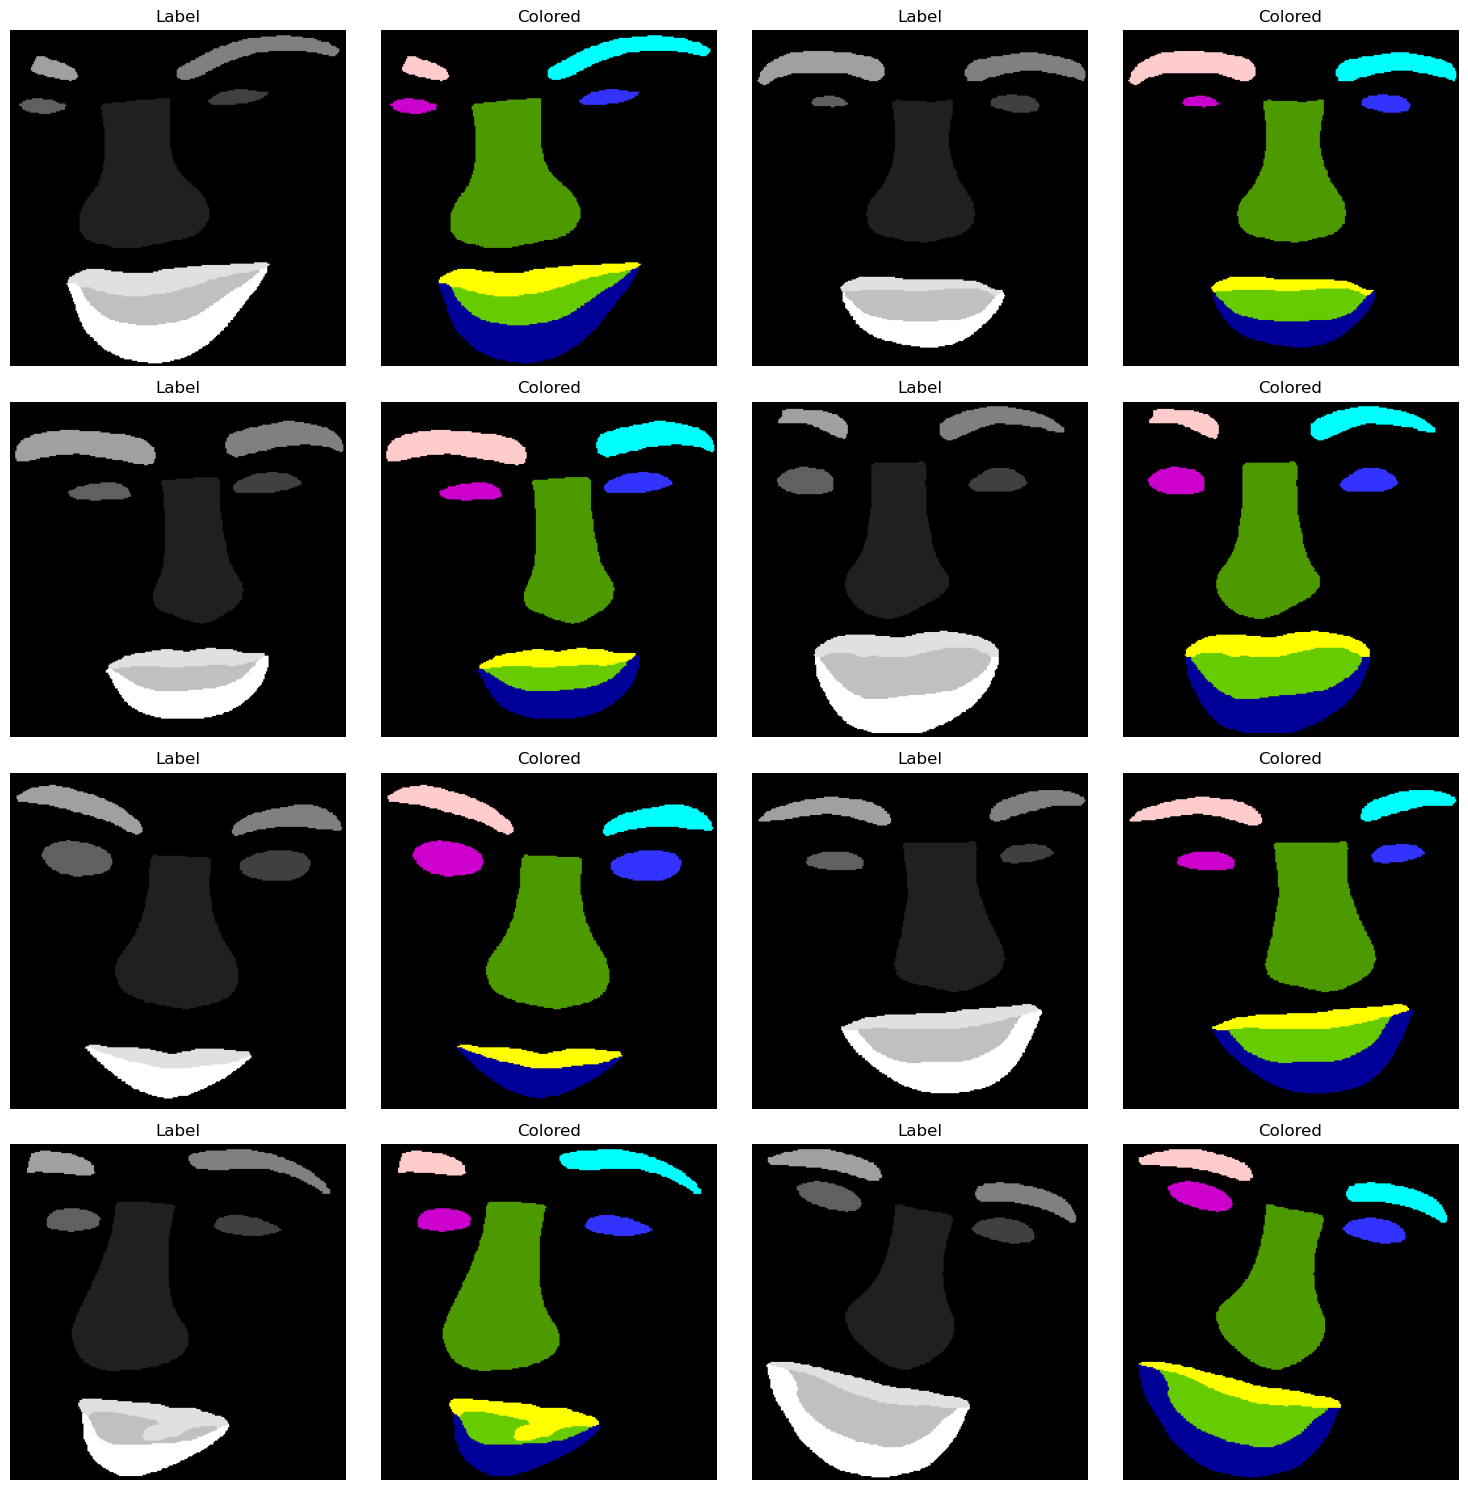

In [ ]:
plt.figure(figsize=(15, 15))
for i, mask_anno in enumerate(train_ds):
    plt.subplot(4, 4, 2*i+1)
    plt.title("Label")
    plt.imshow(mask_anno.numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

    plt.subplot(4, 4, 2*i+2)
    plt.title("Colored")
    cls2clb = label_changing(mask_anno.numpy().astype("uint8"), mode="class2celeb")
    plt.imshow(mask_coloring(cls2clb))
    plt.axis("off")

    if i == 7:
        break

plt.tight_layout()
plt.show()

In [ ]:
print(mask_anno.shape)
print(np.unique(mask_anno))

(256, 256)
[0 1 2 3 4 5 6 7 8]


# Set DL Model

* Make Output Saving Folder

In [ ]:
def make_folder(path):
    if not os.path.exists(os.path.join(path)):
        os.makedirs(os.path.join(path))

In [ ]:
SAVE_DIR = os.path.join(BASE_DIR, "models/cVAE")

In [ ]:
for i in range(1, 6):
    make_folder('{}/fold_{}/checkpoints'.format(SAVE_DIR, i))
    make_folder('{}/fold_{}/sample'.format(SAVE_DIR, i))

* Set Model Structure

In [ ]:
OUTPUT_CHANNEL = 9

class CVAE(tf.keras.Model):
    def __init__(self
                 , latent_dim
                 , fold_num
                 , optimizer=None):

        super(CVAE, self).__init__()
        self.output_dir = SAVE_DIR
        self.latent_dim = latent_dim
        self.fold_num = fold_num
        self.optimizer = optimizer

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
                tf.keras.layers.Conv2D(
                    filters=8, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=16, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8*8*128, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 128)),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=16, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=8, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2D(OUTPUT_CHANNEL, (1, 1)),
            ]
        )

        self.checkpoints = tf.train.Checkpoint(encoder=self.encoder,
                                               decoder=self.decoder,
                                               optimizer = self.optimizer)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))

        return self.decode(eps, apply_softmax=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar, mode='train'):
        if mode == 'train':
            eps = tf.random.normal(shape=mean.shape)
        elif mode == "inference":
            eps = tf.random.normal(shape=mean.shape, seed=1)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_softmax=False):
        logits = self.decoder(z)
        if apply_softmax:
            probs = tf.nn.softmax(logits)
            return probs
        return logits

    def save_models(self):
        self.checkpoints.save(file_prefix = '{}/fold_{}/checkpoints/ckpt'.format(self.output_dir
                                                                                , self.fold_num))

    def load_models(self, idx=None):
        if idx==None:
            ckpt_prefix = '{}/fold_{}/checkpoints'.format(self.output_dir, self.fold_num)
            self.checkpoints.restore(tf.train.latest_checkpoint(ckpt_prefix))
        else:
            self.checkpoints.restore(file_prefix = '{}/fold_{}/checkpoints/ckpt-{}'.format(self.output_dir
                                                                                           , self.fold_num
                                                                                           , idx))
        self.encoder = self.checkpoints.encoder
        self.decoder = self.checkpoints.decoder
        self.optimizer = self.checkpoints.optimizer

In [ ]:
class Training:
    def __init__(self, model):
        self.model = model

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
          -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

    def compute_loss(self, model, x_label):
        mean, logvar = model.encode(tf.expand_dims(x_label, axis=-1))
        z = model.reparameterize(mean, logvar)
        x_logit = model.decode(z)

        cross_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=x_logit, labels=x_label)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)

        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

    @tf.function
    def train_step(self, model, train_data):
        with tf.GradientTape(persistent=True) as tape:
            loss = self.compute_loss(model, train_data)
        gradients = tape.gradient(loss, model.encoder.trainable_variables + model.decoder.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.encoder.trainable_variables + model.decoder.trainable_variables))

        del tape

        return loss

    def generate_and_save_images(self, model, epoch, step, test_sample, num_examples_to_generate=4):
        test_sample = test_sample[0:num_examples_to_generate, :, :]

        mean, logvar = model.encode(tf.expand_dims(test_sample, axis=-1))
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        predictions = tf.argmax(predictions, axis=-1)
        fig = plt.figure(figsize=(15, 15))

        cnt = predictions.shape[0]
        for i in range(cnt):
            plt.subplot(cnt, 4, 4*i + 1)
            plt.title("Input")
            plt.imshow(test_sample[i], cmap='gray')
            plt.axis("off")

            plt.subplot(cnt, 4, 4*i + 2)
            plt.title("Output")
            plt.imshow(predictions[i], cmap='gray')
            plt.axis("off")

            plt.subplot(cnt, 4, 4*i + 3)
            plt.title("Input (Colored)")
            cls2clb = label_changing(test_sample[i].astype('uint8'), mode="class2celeb")
            plt.imshow(mask_coloring(cls2clb))
            plt.axis("off")

            plt.subplot(cnt, 4, 4*i + 4)
            pred_mask = label_changing(predictions[i].numpy().astype("uint8"), mode="class2celeb")
            plt.imshow(mask_coloring(pred_mask))
            plt.title("Output (Colored)")
            plt.axis("off")

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.tight_layout()
        plt.savefig('{}/fold_{}/sample/image_at_epoch_{:04d}_{:04d}.png'.format(model.output_dir
                                                                                , model.fold_num
                                                                                , epoch
                                                                                , step))
        plt.show()

    def train_model(self, train_imgs, val_imgs, epochs=1, batch_size=16):
        train_imgs = tf.data.Dataset.from_tensor_slices(train_imgs)
        train_imgs = train_imgs.batch(batch_size)

        for epoch in range(451, epochs + 1):
            for i, train_anno in enumerate(train_imgs):
                loss = self.train_step(self.model, train_anno)
                if i%40 == 0:
                    display.clear_output(wait=False)
                    print("Epoch: {}, Step: {}, Loss: {:.3f}".format(epoch, i, loss.numpy()))
                    self.generate_and_save_images(self.model, epoch, i, val_imgs)
            if epoch % 50 == 0:
                self.model.save_models()

# Training

In [ ]:
epochs = 500
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 10
num_examples_to_generate = 4

* Set K-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS)

train_ds_arr = np.array(list(train_ds.as_numpy_iterator()))
train_target_arr = np.array([1 for _ in range(len(train_ds))])

In [ ]:
print(train_ds_arr.shape)
print(train_target_arr.shape)

(2162, 256, 256)
(2162,)


* Training

Epoch: 500, Step: 80, Loss: 4867.902


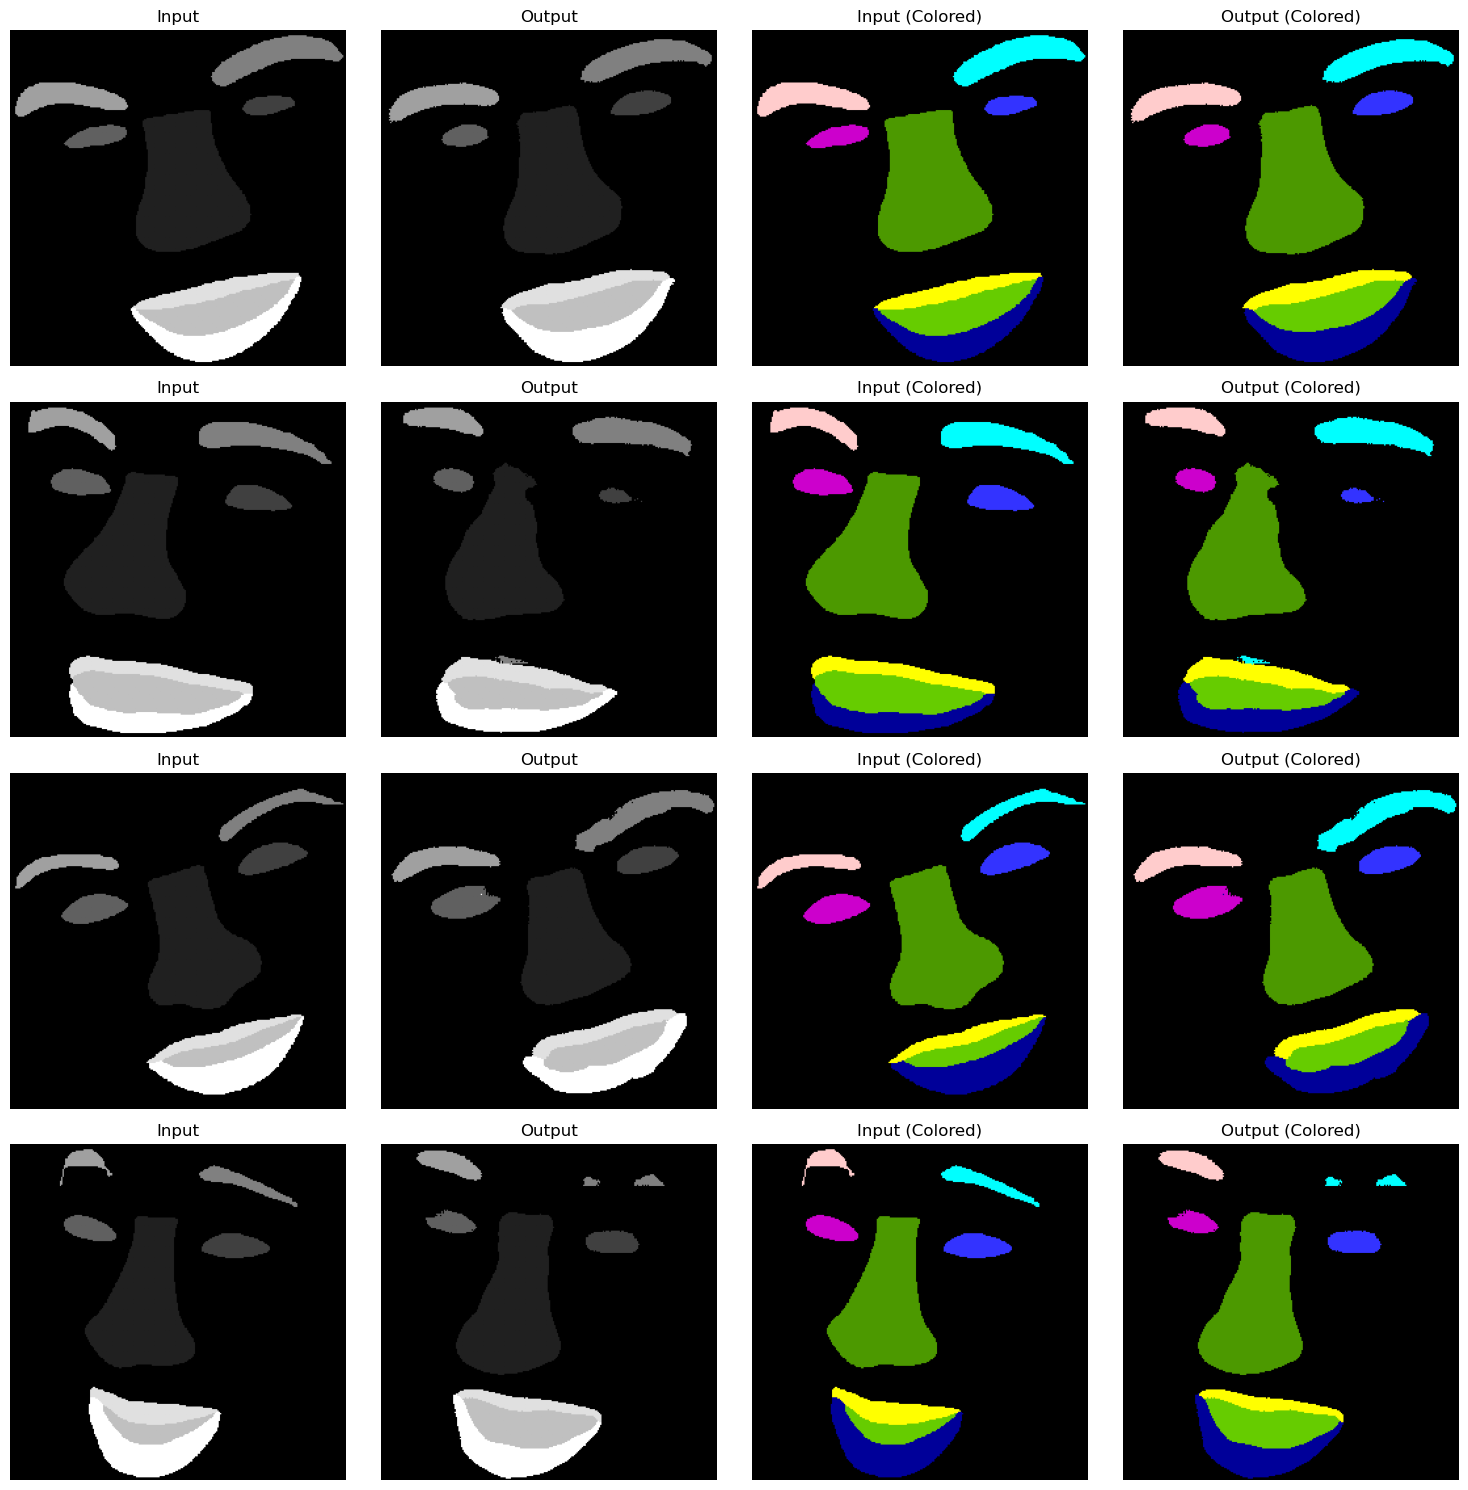

In [ ]:
fold_num = 1
for train_idx, val_idx in skf.split(train_ds_arr, train_target_arr):
    train_imgs, val_imgs = train_ds_arr[train_idx], train_ds_arr[val_idx]

    # Set Model of each fold
    model = CVAE(latent_dim=latent_dim
                 , fold_num=fold_num
                 , optimizer = tf.keras.optimizers.Adam(1e-4))

    tn = Training(model=model)
    tn.train_model(train_imgs=train_imgs
                   , val_imgs=val_imgs
                   , epochs=epochs
                   , batch_size=16)

    fold_num += 1

# Evaluation

In [ ]:
from sklearn.model_selection import StratifiedKFold

class Evaluation:
    def __init__(self, model, fold_num):
        self.model = model
        self.fold_num = fold_num

        self.model.load_models()

    def evaluation(self,
                   data_X,
                   data_Y,
                   NUM_FOLDS=5,
                   num_examples_to_generate = 8):

        skf = StratifiedKFold(n_splits=NUM_FOLDS)

        temp_fold = 1
        for train_idx, val_idx in skf.split(data_X, data_Y):
            if temp_fold == self.fold_num:
                train_ns_imgs, val_ns_imgs = data_X[train_idx], data_X[val_idx]

                val_ns_imgs = tf.data.Dataset.from_tensor_slices(val_ns_imgs).batch(batch_size)

                for test_batch_label in val_ns_imgs.take(1):
                    test_ns_label = test_batch_label[0:num_examples_to_generate, :, :]

                mean, logvar = self.model.encode(tf.expand_dims(test_ns_label, axis=-1))
                z = self.model.reparameterize(mean, logvar)
                predictions = self.model.sample(z)
                predictions = tf.argmax(predictions, axis=-1)
                fig = plt.figure(figsize=(15, 30))

                cnt = predictions.shape[0]
                for i in range(cnt):
                    plt.subplot(cnt, 4, 4*i + 1)
                    plt.title("Input")
                    plt.imshow(test_ns_label[i], cmap='gray')
                    plt.axis("off")

                    plt.subplot(cnt, 4, 4*i + 2)
                    plt.title("Output")
                    plt.imshow(predictions[i], cmap='gray')
                    plt.axis("off")

                    plt.subplot(cnt, 4, 4*i + 3)
                    plt.title("Input (Colored)")
                    cls2clb = label_changing(test_ns_label[i].numpy().astype('uint8'), mode="class2celeb")
                    plt.imshow(mask_coloring(cls2clb))
                    plt.axis("off")

                    plt.subplot(cnt, 4, 4*i + 4)
                    pred_mask = label_changing(predictions[i].numpy().astype("uint8"), mode="class2celeb")
                    plt.imshow(mask_coloring(pred_mask))
                    plt.title("Output (Colored)")
                    plt.axis("off")

                # tight_layout minimizes the overlap between 2 sub-plots
                plt.tight_layout()
                plt.show()
                break

            temp_fold += 1

* Load Non-Smiling Images

In [ ]:
ns_dataset = os.path.join(BASE_DIR, 'Datasets/GENKI_seg/non_smile/labels/face_*.png')

In [ ]:
ns_dataset_path = glob.glob(ns_dataset)
ns_dataset_path.sort(reverse=True)
ns_dataset_path = tf.data.Dataset.from_tensor_slices(ns_dataset_path)

In [ ]:
ns_ds = ns_dataset_path.map(lambda item: tf.py_function(map_func, [item], tf.int32))

ns_ds_arr = np.array(list(ns_ds.as_numpy_iterator()))
ns_target_arr = np.array([0 for _ in range(len(ns_ds))])

* evaluation

In [ ]:
target_fold_num = 5

model = CVAE(latent_dim=10
            , fold_num = target_fold_num
            , optimizer = tf.keras.optimizers.Adam(1e-4))

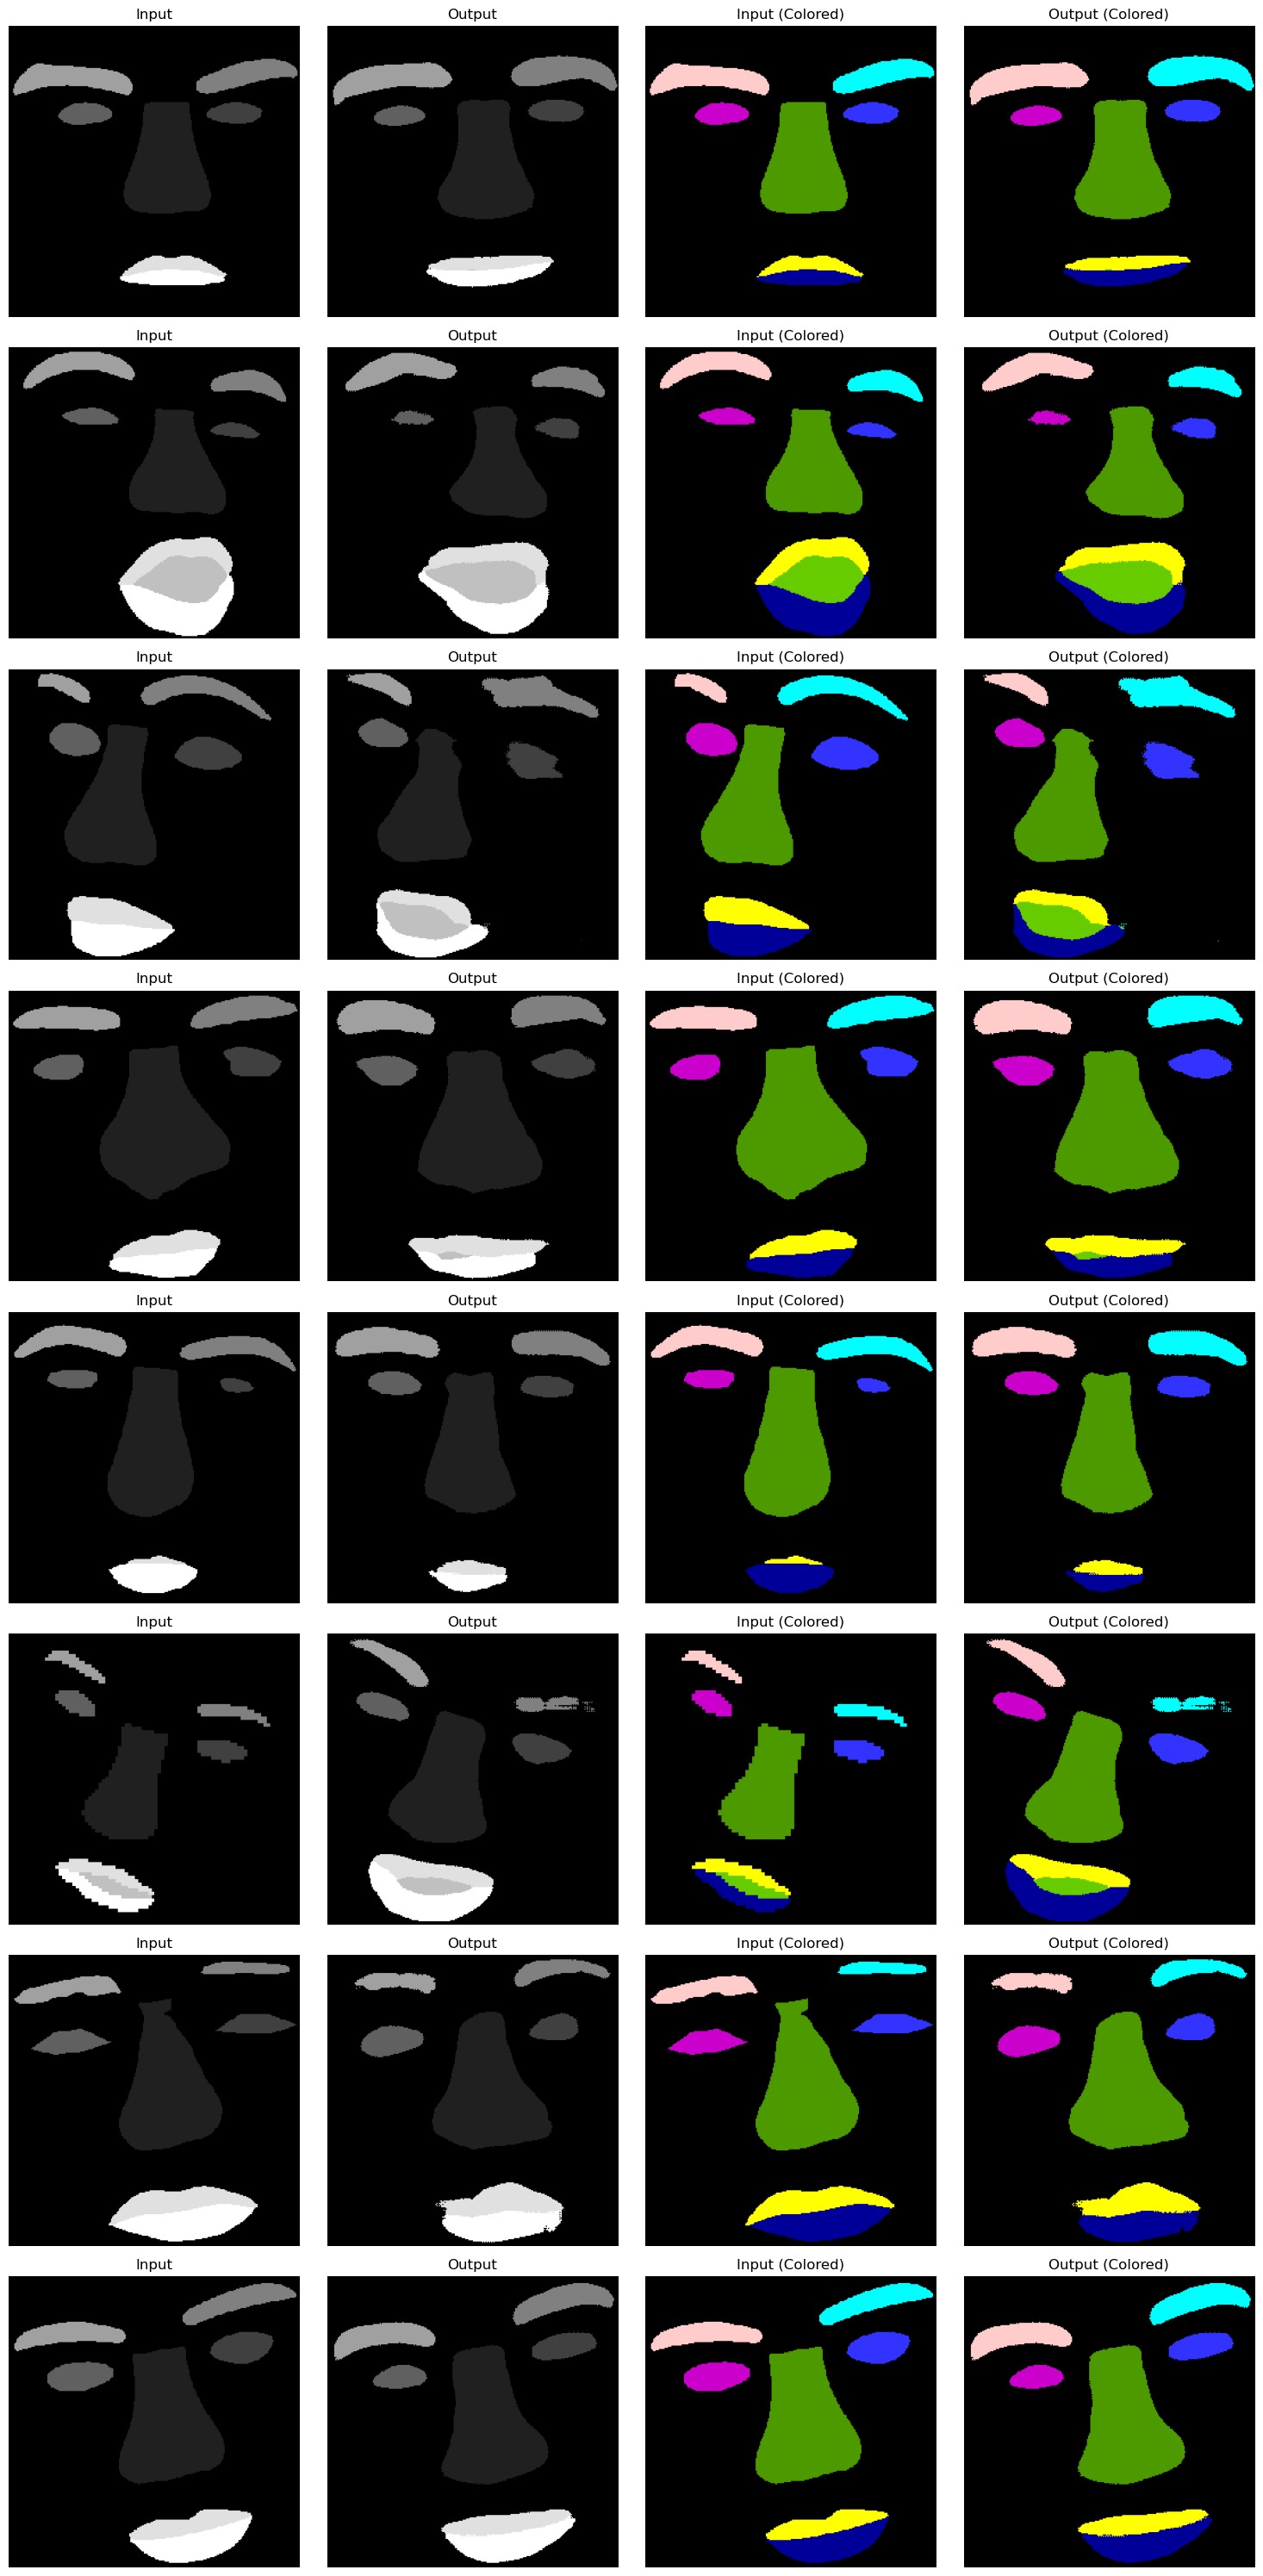

In [ ]:
ev = Evaluation(model=model,
                fold_num = target_fold_num)

ev.evaluation(data_X=ns_ds_arr,
              data_Y=ns_target_arr)